# Data Preprocessing and Loading

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# PyTorch version
print(torch.__version__)

1.12.0


In [18]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 标准化
])

# CIFAR10 dataset
trainset = CIFAR10(root='./data', train=True, download=False, transform=transform)
testset = CIFAR10(root='./data', train=False, download=False, transform=transform)

# Select classes
selected_classes = [0, 1, 2, 3, 4, 6]
train_indices = [i for i, label in enumerate(trainset.targets) if label in selected_classes]
test_indices = [i for i, label in enumerate(testset.targets) if label in selected_classes]

trainset = Subset(trainset, train_indices)
testset = Subset(testset, test_indices)


In [19]:
label_map = {label: i for i, label in enumerate(selected_classes)}
label_map

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 6: 5}

In [ ]:
# Change labels
for i in train_indices:
    trainset.dataset.targets[i] = label_map[trainset.dataset.targets[i]]
for i in test_indices:
    testset.dataset.targets[i] = label_map[testset.dataset.targets[i]]

In [21]:
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Data Visualization

In [27]:
for img, label in trainset:
    print(img.shape, label)
    break

torch.Size([3, 32, 32]) 5


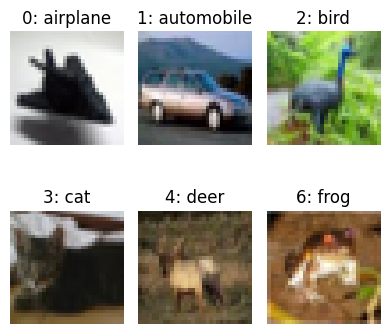

In [63]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_names = np.array(class_names)[selected_classes]

# Visualize one image of each class
fig, axs = plt.subplots(2, 3, figsize=(4, 4))
for i, ax in enumerate(axs.flat):
    # matching_images = [img for img, label in trainset if label == i]
    # img = random.choice(matching_images)  # too slow
    img = next(img for img, label in trainset if label == i)
    img = 0.5 * img + 0.5  # unnormalize
    img = img.numpy().transpose(1, 2, 0)
    ax.imshow(img)
    ax.set_title(f'{selected_classes[i]}: {class_names[i]}')
    ax.axis('off')

plt.tight_layout()
plt.show()


# Custom CNN

In [59]:
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 6)  # 输出6个类别

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)  # 展平
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Training

In [64]:
# 初始化模型、损失函数和优化器
model = CustomCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 10
loss_values = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(trainloader)
    loss_values.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')


Epoch [1/10], Loss: 1.0664
Epoch [2/10], Loss: 0.7869
Epoch [3/10], Loss: 0.6675
Epoch [4/10], Loss: 0.5842
Epoch [5/10], Loss: 0.5124
Epoch [6/10], Loss: 0.4391
Epoch [7/10], Loss: 0.3782
Epoch [8/10], Loss: 0.3071
Epoch [9/10], Loss: 0.2454
Epoch [10/10], Loss: 0.1892


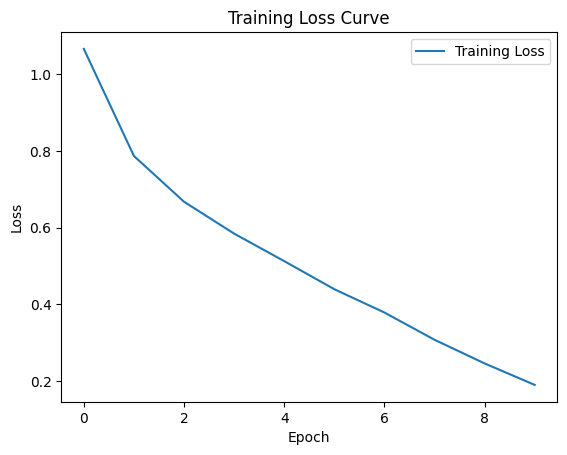

In [65]:
# Plot the training loss curve
plt.plot(loss_values, label='Training Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluation

In [66]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix

# 模型评估函数
def evaluate(model, dataloader):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            probs = torch.softmax(outputs, dim=1)  # 获取每个类别的概率
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.numpy())
    
    # 计算评估指标
    acc = accuracy_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    cm = confusion_matrix(all_labels, all_preds)
    
    # 计算 AUROC
    if len(set(all_labels)) == 2:  # 二分类
        auroc = roc_auc_score(all_labels, [p[1] for p in all_probs])
    else:  # 多分类
        auroc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
    
    print(f'Accuracy: {acc:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, F1 Score: {f1:.4f}, AUROC: {auroc:.4f}')
    return cm

# 评估模型
cm = evaluate(model, testloader)

Accuracy: 0.7672, Recall: 0.7672, Precision: 0.7670, F1 Score: 0.7657, AUROC: 0.9529


# Results Visulization

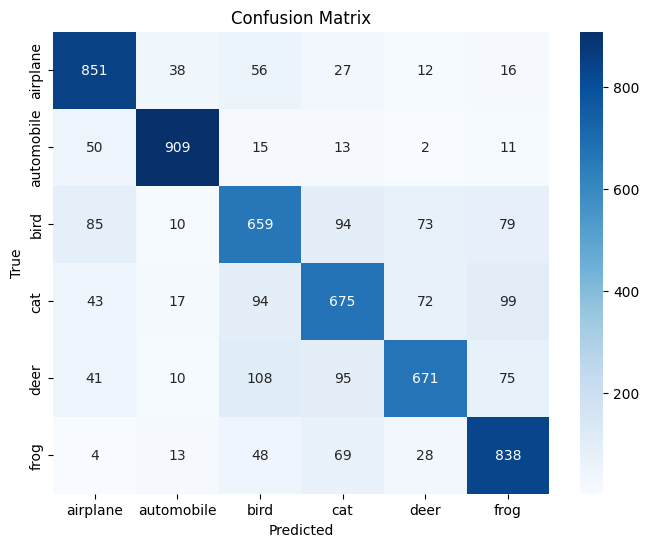

In [67]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
